In [35]:
# Imports for data handling
import numpy  as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt


# Imports for machine learning model
from sklearn.model_selection import train_test_split

# Splitting data for training and evalution of the model

In [2]:
dataset = pd.read_csv('../data/original_data.csv', parse_dates=['Timestamp'])
dataset.shape

(5000, 13)

In [3]:
dataset.head(5)

,Transaction_ID,Timestamp,Vehicle_Type,FastagID,TollBoothID,Lane_Type,Vehicle_Dimensions,Transaction_Amount,Amount_paid,Geographical_Location,Vehicle_Speed,Vehicle_Plate_Number,Fraud_indicator
0,1,2023-01-06 11:20:00,Bus,FTG-001-ABC-121,A-101,Express,Large,350,120,"13.059816123454882, 77.77068662374292",65,KA11AB1234,Fraud
1,2,2023-01-07 14:55:00,Car,FTG-002-XYZ-451,B-102,Regular,Small,120,100,"13.059816123454882, 77.77068662374292",78,KA66CD5678,Fraud
2,3,2023-01-08 18:25:00,Motorcycle,NaN,D-104,Regular,Small,0,0,"13.059816123454882, 77.77068662374292",53,KA88EF9012,Not Fraud
3,4,2023-01-09 02:05:00,Truck,FTG-044-LMN-322,C-103,Regular,Large,350,120,"13.059816123454882, 77.77068662374292",92,KA11GH3456,Fraud
4,5,2023-01-10 06:35:00,Van,FTG-505-DEF-652,B-102,Express,Medium,140,100,"13.059816123454882, 77.77068662374292",60,KA44IJ6789,Fraud


This dataset has biggest challenges in data handling compared to the last project.
As you can see there are many text columns and some of them need to be handled to extract the max prediction power possible.

Here are some ideas we will try:
- Instead of split the dataset into aleatory train and test, split using cronological criteria
- Split date and time, maybe frauds could happens more in an certain time
- Create historical features for example: how many frauds this customer had? how many frauds in this place?

# Timestamp analysis

In [4]:
dataset['Date'] = dataset['Timestamp'].dt.date
dataset['Day']  = dataset['Timestamp'].dt.day
dataset['Hour'] = dataset['Timestamp'].dt.hour
dataset.head(5)

,Transaction_ID,Timestamp,Vehicle_Type,FastagID,TollBoothID,Lane_Type,Vehicle_Dimensions,Transaction_Amount,Amount_paid,Geographical_Location,Vehicle_Speed,Vehicle_Plate_Number,Fraud_indicator,Date,Day,Hour
0,1,2023-01-06 11:20:00,Bus,FTG-001-ABC-121,A-101,Express,Large,350,120,"13.059816123454882, 77.77068662374292",65,KA11AB1234,Fraud,2023-01-06,6,11
1,2,2023-01-07 14:55:00,Car,FTG-002-XYZ-451,B-102,Regular,Small,120,100,"13.059816123454882, 77.77068662374292",78,KA66CD5678,Fraud,2023-01-07,7,14
2,3,2023-01-08 18:25:00,Motorcycle,NaN,D-104,Regular,Small,0,0,"13.059816123454882, 77.77068662374292",53,KA88EF9012,Not Fraud,2023-01-08,8,18
3,4,2023-01-09 02:05:00,Truck,FTG-044-LMN-322,C-103,Regular,Large,350,120,"13.059816123454882, 77.77068662374292",92,KA11GH3456,Fraud,2023-01-09,9,2
4,5,2023-01-10 06:35:00,Van,FTG-505-DEF-652,B-102,Express,Medium,140,100,"13.059816123454882, 77.77068662374292",60,KA44IJ6789,Fraud,2023-01-10,10,6


In [5]:
# There are only data of 2023
category_counts = dataset['Timestamp'].dt.year.value_counts()
display(category_counts)


Timestamp
2023    5000
Name: count, dtype: int64

In [6]:
# We can see that the data is balanced  along the months.
# An ideia is to split the train data until October and use November + December as test data
category_counts = dataset['Timestamp'].dt.month.value_counts()
display(category_counts)


Timestamp
1     546
3     514
2     511
4     462
5     445
6     418
7     378
8     374
9     363
10    338
11    327
12    324
Name: count, dtype: int64

In [7]:
# Splitting into train and test using the timestamp column
## The idea is to use older data to train and newer data to test, this can bring more confidence that the model is usable with new data
df_sorted = dataset.sort_values(by='Timestamp')

split_date = pd.to_datetime('2023-11-01')
train_df = df_sorted[df_sorted['Timestamp'] < split_date]
test_df = df_sorted[df_sorted['Timestamp'] >= split_date]

In [8]:
y_train = train_df['Fraud_indicator']
X_train = train_df.drop(['Fraud_indicator'], axis=1)

y_test = test_df['Fraud_indicator']
X_test = test_df.drop(['Fraud_indicator'], axis=1)

# Data exploration and cleaning

## Vehicle_Type
- simple encoding
- remove blank spaces in the string
- vehicle can have correlation with toll value

In [9]:
# Checking vehicle types
category_counts = X_train['Vehicle_Type'].value_counts()
display(category_counts)

Vehicle_Type
SUV           627
Bus           625
Van           621
Car           621
Truck         620
Sedan         619
Motorcycle    616
Name: count, dtype: int64

In [10]:
# It's possible to make an simple encoding
## we used the strip() method to remove any blank spaces that could cause error
## I did it here just to study, when we deploy the app, all those cleanings will be applied when the input comes

vehicle_dict = {"SUV"       : 1 ,
                "Bus"       : 2 ,
                "Van"       : 3 ,
                "Car"       : 4 ,
                "Truck"     : 5 ,
                "Sedan"     : 6 ,
                "Motorcycle": 7 }

X_train["Vehicle_Type"] = X_train.Vehicle_Type.str.strip().apply(lambda x: vehicle_dict[x])

X_train.Vehicle_Type.value_counts()

Vehicle_Type
1    627
2    625
3    621
4    621
5    620
6    619
7    616
Name: count, dtype: int64

## FastagID
- It's the pre-paid tag id
- Turn this column into "has fasttag or not"

Questions
- Can it be in different vehicles of the same owner? I checked and no
- Makes sense to keep it in the dataset? Not this way, all unique values or Na
- Can we use this column in some way? Yes, we can create a Flag indicating if it has tag or not

In [11]:
X_train.shape

(4349, 15)

In [12]:
X_train['FastagID'].nunique()

3883

In [13]:
X_train['FastagID'].isna().sum()

np.int64(466)

In [14]:
X_train['FastagID'] = np.where(X_train['FastagID'].isna(), 0, 1)
X_train.FastagID.value_counts()

FastagID
1    3883
0     466
Name: count, dtype: int64

## TollBoothID
- Used for pinpointing locations

Questions
- How many categories exist? It will be possible to use it this way? Only 6.
- Can it become an flag feature indicating high and low fraud tollbooth? There are just 6 categories of this feature, that could be an good idea if there were multiple categories.

In [17]:
X_train['TollBoothID'].nunique()

6

In [18]:
X_train['TollBoothID'].isna().sum()

np.int64(0)

In [20]:
print(X_train['TollBoothID'].unique())

['D-106' 'A-101' 'B-102' 'C-103' 'D-105' 'D-104']


In [ ]:
toolbooth_dict = {"D-106" : 1 ,
                  "A-101" : 2 ,
                  "B-102" : 3 ,
                  "C-103" : 4 ,
                  "D-105" : 5 ,
                  "D-104" : 6 
                   }

X_train["TollBoothID"] = X_train.TollBoothID.str.strip().apply(lambda x: toolbooth_dict[x])

X_train.TollBoothID.value_counts()

TollBoothID
3    1252
4    1241
2    1240
1     489
5      89
6      38
Name: count, dtype: int64

# Lane_Type
- The specific lane for the transaction

Questions
- Is there any lane usually used to make frauds?
- Is there because of a fraudulent behavior or it's just coincidence?

In [27]:
X_train['Lane_Type'].nunique()

2

In [28]:
print(X_train['Lane_Type'].unique())

['Regular' 'Express']


In [29]:
lane_dict = {"Regular" : 1 ,
             "Express" : 2 }

X_train["Lane_Type"] = X_train.Lane_Type.str.strip().apply(lambda x: lane_dict[x])

X_train.Lane_Type.value_counts()

Lane_Type
1    2480
2    1869
Name: count, dtype: int64

# Vehicle_Dimensions

Questions
- Is there any size of vehicles used to make frauds?

In [32]:
X_train['Vehicle_Dimensions'].nunique()

3

In [33]:
print(X_train['Vehicle_Dimensions'].unique())

['Small' 'Medium' 'Large']


In [34]:
dimensions_dict = {"Small"  : 1 ,
                   "Medium" : 2 ,
                   "Large"  : 3 }

X_train["Vehicle_Dimensions"] = X_train.Vehicle_Dimensions.str.strip().apply(lambda x: dimensions_dict[x])

X_train.Vehicle_Dimensions.value_counts()

Vehicle_Dimensions
3    1872
2    1240
1    1237
Name: count, dtype: int64

# Transaction_Amount

Questions
- Is there any pattern relacted to the amount o the transaction in fraud occurences?

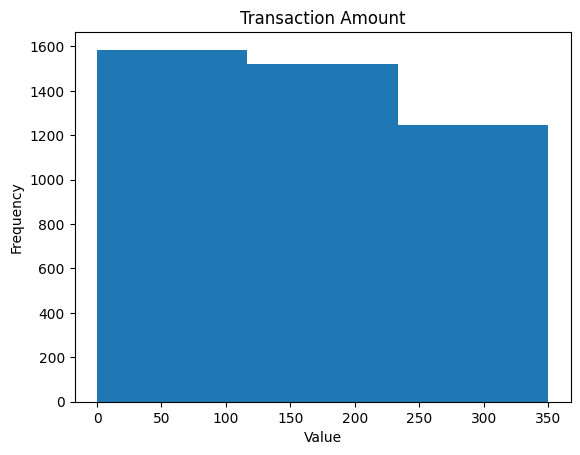

In [50]:
plt.hist(X_train['Transaction_Amount'], bins=3)
plt.title('Transaction Amount')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:

# Checking the best way to cut the continuous column into bins
X_train['Transaction_Amount_test'] = pd.cut(X_train['Transaction_Amount'], bins=3) # Creates 5 equal-width bins
X_train.Transaction_Amount_test.value_counts()

Transaction_Amount_test
(-0.35, 116.667]      1585
(116.667, 233.333]    1519
(233.333, 350.0]      1245
Name: count, dtype: int64

In [59]:
# Applying the specific cut to the dataframe
## This is step is important to make the same splits of categories into new data
## 0 = values below 115
## 1 = values between 116 and 230
## 2 = values between 231 and 350
## 3 = values above 351

bins = [-999999, 115, 230, 350, 99999]
labels = ['0', '1', '2', '3']
X_train['Transaction_Amount'] = pd.cut(X_train['Transaction_Amount'] , bins=bins, labels=labels, right=True)
X_train.Transaction_Amount.value_counts()

Transaction_Amount
0    1585
1    1519
2    1245
3       0
Name: count, dtype: int64